In [1]:
!pip install pytube3


In [2]:
from pytube import YouTube

In [218]:
yt = YouTube('https://www.youtube.com/watch?v=tsu8udPhn5U')

In [235]:
yt.streams.all()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  """Entry point for launching an IPython kernel.


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">,
 <Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">,
 <Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">,
 <Stream: itag="244" mime_type="video/webm" res="480p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream:

In [236]:
video_name = yt.streams.get_by_itag('134').download()

In [237]:
import cv2
import shutil
import os
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip


In [269]:
start_time, end_time = (5, 111)
ffmpeg_extract_subclip(video_name, start_time, end_time, targetname="test.mp4")


[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/Aurora Borealis Time Lapse Movie.mp4 -ss 5.00 -t 106.00 -vcodec copy -acodec copy test.mp4
... command successful.


In [270]:
def video_to_frames(video_path, new_folder_path, size = (64,64)):
    frames_paths = []
    try:
        os.mkdir(new_folder_path)
    except:
        shutil.rmtree(new_folder_path)
        os.mkdir(new_folder_path) 
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0

    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:

            image = cv2.resize(image,size)
            cv2.imwrite(fmt_name, image)
            frames_paths.append(fmt_name)

            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)
    return frames_paths

In [271]:
!rm -rf frames

In [315]:
frames_paths = video_to_frames(video_path = "test.mp4", 
                               new_folder_path = "frames", size = (256, 256))

saved  3030  frames at  frames


In [316]:
len(frames_paths)

3031

In [317]:
# !tar -zcvf forest_GAN_images.tar.gz frames


In [318]:
# !cp -v  /content/forest_GAN_images.tar.gz /content/drive/"My Drive"/forest_GAN/


In [319]:
from torch.optim import Adam
import torch.cuda as cuda
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image, ImageEnhance 
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import DataLoader
import torch
from numpy import moveaxis
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
from IPython.display import clear_output
from albumentations import *
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils


In [320]:
class ImageDataset(Dataset):   
    def __init__(self, filenames , transform = None):
        
        self.image_paths =filenames
        
        self.transform = transform
       
    def __getitem__(self, idx):
        path = self.image_paths[idx]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return self.transform(image)

    def __len__(self):
        return len(self.image_paths)

In [321]:
full_dataset = ImageDataset(filenames = frames_paths,
                                transform = transforms.Compose([    
                                                                transforms.ToPILImage(),
                                                                transforms.Resize((256, 256), interpolation = Image.NEAREST),
                                                                # torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                                ToTensor(),
                                                                # transforms.Normalize(0.5, 0.5, 0.5)
                                                                ])
                                )                            

In [364]:
dataloader = DataLoader(dataset=full_dataset, batch_size=16, shuffle=True)  ## 16-32-64  is good, 256 if you're feeling brave
print(len(dataloader), "batches ")

190 batches 


In [323]:
def show_batch(batch):
    fig, ax = plt.subplots(5,3, figsize = (15,20))
    images = batch
    for i in range (15):
        image_np = np.moveaxis(images[i].numpy(),0,2)
        ax.flat[i].imshow(image_np)


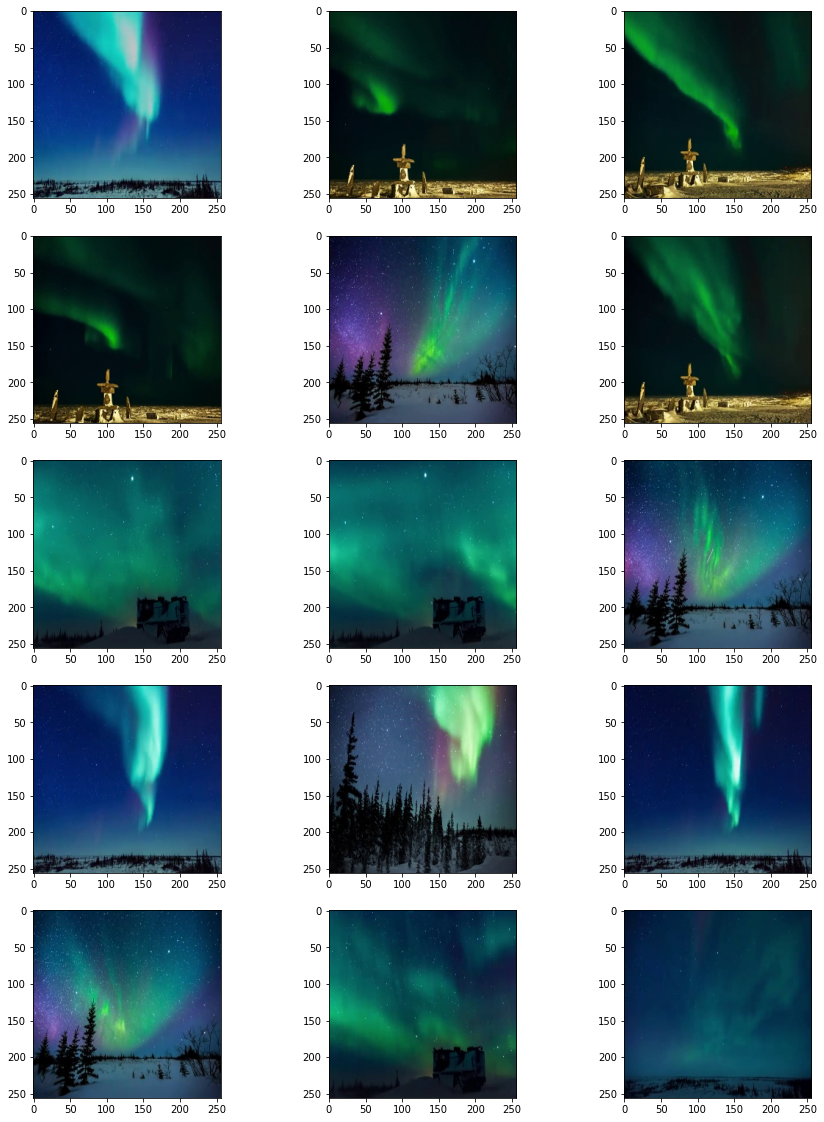

In [324]:
batch = next(iter(dataloader))
show_batch(batch)

In [325]:
torch.max(batch), torch.min(batch)

(tensor(1.), tensor(0.))

In [327]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [328]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.latent_vector_size = 128
        self.init_size = 256 // 4
        self.l1 = nn.Sequential(nn.Linear(self.latent_vector_size, 128 * self.init_size ** 2 *2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):

        out = self.l1(z)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [329]:
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

netG = Generator().to(device)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=128, out_features=1048576, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)


In [330]:
netG(torch.zeros([1,128]).cuda()).size()

torch.Size([1, 3, 256, 256])

In [346]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 64, bn=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
        )

        # The height and width of downsampled image
        ds_size = 256 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [347]:


netD = Discriminator().to(device)



# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ad

In [348]:
netD(torch.zeros([1,3,256,256]).cuda()).view(-1)

tensor([0.4987], device='cuda:0', grad_fn=<ViewBackward>)

In [349]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 256, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Learning rate for optimizers
lr = 0.00008

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [390]:
ROOT = "/content/drive/My Drive/auroraGAN/"

# netG.load_state_dict(torch.load(ROOT + "generator.pth"))
# netD.load_state_dict(torch.load(ROOT + "discriminator.pth"))

In [350]:
#  Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


In [351]:
import random
random.random()

0.7391547119457698

In [ ]:

num_epochs = 10
netG.train()

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in tqdm(enumerate(dataloader, 0)):
        noise = (random.random() - 0.5)/10

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)

        real_label =torch.ones(b_size).cuda() + noise
        fake_label = torch.zeros(b_size).cuda() + noise

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, real_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, netG.latent_vector_size,device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, fake_label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, real_label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        

In [397]:
torch.save(netG.state_dict(), ROOT + "generator.pth")
torch.save(netD.state_dict(), ROOT + "discriminator.pth")

In [406]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
    

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=60):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

In [403]:
# generate points in latent space
images = []
n = 10
pts = generate_latent_points(128, n)
# interpolate pairs
results = None
for i in range(0, n-1, 1):
    # interpolate points in latent space
    interpolated = interpolate_points(pts[i], pts[i+1], n_steps = 10)
    
    z = torch.tensor(interpolated).float().cuda()
    image = netG(z).cpu().detach().numpy()
    
    for i in range(image.shape[0]):

        image_np = np.moveaxis(image[i], 0,2)

        images.append(image_np)

In [404]:
len(images)

90

In [405]:
np.max(images[0]), np.min(images[0])

(0.96416247, -0.36144754)

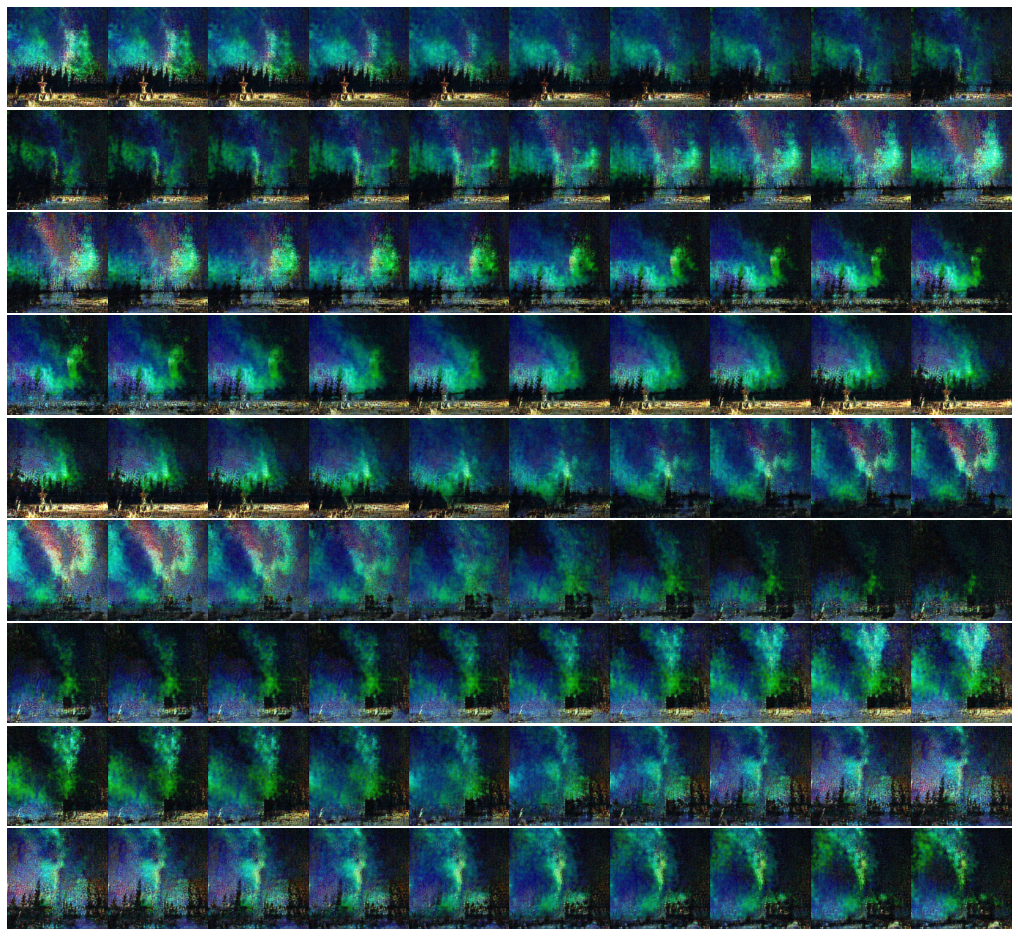

In [396]:
fig,ax =  plt.subplots(9,10, figsize = (18,17.0))
for i in range(len(images)):
    frame =  cv2.convertScaleAbs(images[i], alpha = 255)

    ax.flat[i].imshow(frame)
    ax.flat[i].axis('off')
fig.subplots_adjust(wspace=0, hspace=0)


In [409]:
# generate points in latent space
all_images = []
n = 20
pts = generate_latent_points(128, n)
# interpolate pairs
results = None
for i in range(0, n-1, 1):
    # interpolate points in latent space
    interpolated = interpolate_points(pts[i], pts[i+1], n_steps = 60)
    
    z = torch.tensor(interpolated).float().cuda()
    image = netG(z).cpu().detach().numpy()
    
    for i in range(image.shape[0]):

        image_np = np.moveaxis(image[i], 0,2)

        all_images.append(image_np)

all_images = np.array(images)

In [410]:
all_images.shape


(1140, 256, 256, 3)

In [411]:
def write_video_from_image_list(save_name, all_images_np, framerate, size):
    fourcc = cv2.VideoWriter_fourcc("m", "p", "4", "v")
    out = cv2.VideoWriter(save_name ,fourcc, framerate, size)

    for i in range(all_images_np.shape[0]):
        
        frame = all_images_np[i]
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frame = cv2.convertScaleAbs(frame, alpha = 255)

        frame = cv2.resize(frame, (256,256))
        # print(frame.shape)

        out.write(frame)
    out.release()

In [412]:
write_video_from_image_list(save_name = "interp_aurora.mp4",
                            all_images_np = all_images,
                            framerate = 60,
                            size = (256,256))
